# CIFAR10 classification using Neural Networks

In [14]:
%matplotlib inline

# Load CIFAR10 Dataset using torchvision

In [15]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import gc

In [16]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )
transform = transforms.Compose([
          transforms.Resize((224,224)),
          transforms.ToTensor(),
          normalize,
  ])
# Classes of CIFAR10 with label number for easy look up
classes = {0:'plane', 1:'car', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

# define batch size
batch_size = 16

# Train set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True, num_workers=2,pin_memory=True)

# Test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2,pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# look at train set
print(trainset)
# print out tensor shape and corresponding label of one image.
random_image = trainset[5][0]
random_image_label = trainset[5][1]
print(random_image.shape,random_image_label)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.201])
           )
torch.Size([3, 224, 224]) 1


The label of the image is: car


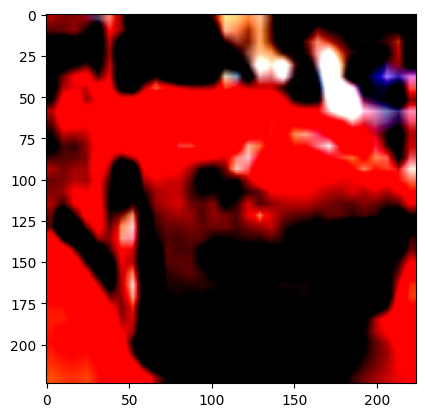

In [19]:
# Print the Image using Matplotlib
plt.imshow(np.transpose(random_image, (1, 2, 0)))
print("The label of the image is:", classes[random_image_label])

# Visualize some images of a batch

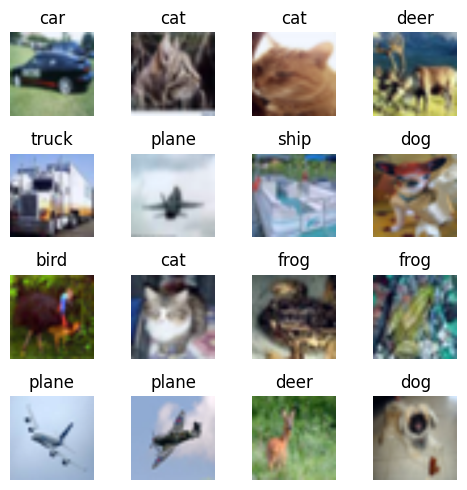

In [20]:
batch, labels = next(iter(trainloader))

plt.figure(figsize=(5, 5))
for i in range(16):
    plt.subplot(4, 4, i+1)
    # De-normalize
    t = batch[i]
    min, max = torch.min(t), torch.max(t)
    im = np.transpose((t-min)/(max-min), (1, 2, 0)).numpy()
    plt.imshow(im)
    plt.title(classes[labels.numpy()[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()

# Costruct ResNet18 Architecture
From: https://blog.paperspace.com/writing-resnet-from-scratch-in-pytorch/ 

In [21]:
# Define residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [22]:
# ResNet18
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# Training

In [26]:
num_classes = 10
num_epochs = 30
learning_rate = 0.01

print('torch.cuda.is_available()', torch.cuda.is_available())
model = ResNet(ResidualBlock, [2, 2, 2, 2]).to(device)

# cross entropy Loss and SGD optimizer with momentum
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.001, momentum = 0.9)  

# Train the model
total_step = len(trainloader)

torch.cuda.is_available() True


In [27]:
train_loss = []
test_loss = []
accuracy = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(trainloader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1, num_epochs, loss.item()))
    train_loss.append(loss.item())

            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
    
        print('Accuracy of the network on the {} validation images: {} %'.format(50000, 100 * correct / total)) 
        test_loss.append(loss.item())
        accuracy.append(100 * correct / total)

Epoch [1/30], Loss: 0.7501
Accuracy of the network on the 50000 validation images: 56.63 %
Epoch [2/30], Loss: 0.7608
Accuracy of the network on the 50000 validation images: 72.37 %
Epoch [3/30], Loss: 0.7889
Accuracy of the network on the 50000 validation images: 76.31 %
Epoch [4/30], Loss: 0.2838
Accuracy of the network on the 50000 validation images: 77.56 %
Epoch [5/30], Loss: 0.8085
Accuracy of the network on the 50000 validation images: 78.18 %
Epoch [6/30], Loss: 0.1225
Accuracy of the network on the 50000 validation images: 79.76 %
Epoch [7/30], Loss: 0.6852
Accuracy of the network on the 50000 validation images: 81.55 %
Epoch [8/30], Loss: 0.4738
Accuracy of the network on the 50000 validation images: 79.24 %
Epoch [9/30], Loss: 0.2483
Accuracy of the network on the 50000 validation images: 79.85 %
Epoch [10/30], Loss: 0.3400
Accuracy of the network on the 50000 validation images: 80.86 %
Epoch [11/30], Loss: 0.1766
Accuracy of the network on the 50000 validation images: 82.38

# Plot Losses and Accuracy

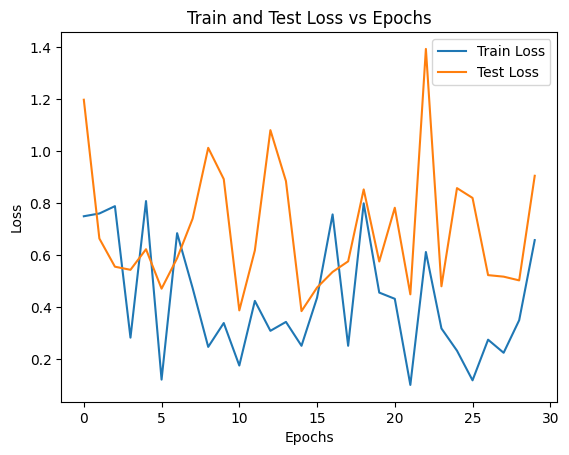

In [28]:
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title("Train and Test Loss vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

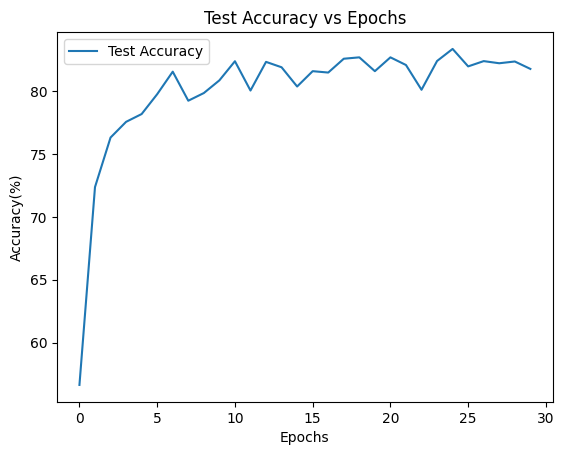

In [29]:
plt.plot(accuracy, label='Test Accuracy')
plt.title("Test Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()